In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os

2023-05-23 10:49:24.498824: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-23 10:49:25.441799: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
from tensorflow.keras.models import Model
import tensorflow as tf

# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tensorflow.keras.applications import InceptionResNetV2, ResNet50, InceptionV3, DenseNet121, Xception

In [3]:
import numpy as np
from tensorflow import keras

# Make model
model = keras.models.load_model('../results/models/model_Xception_imagenet_052223.h5')
model.summary()

2023-05-23 10:49:29.250460: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 18237 MB memory:  -> device: 0, name: NVIDIA RTX A4500, pci bus id: 0000:81:00.0, compute capability: 8.6
2023-05-23 10:49:29.251164: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 10302 MB memory:  -> device: 1, name: NVIDIA TITAN V, pci bus id: 0000:02:00.0, compute capability: 7.0


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 512, 512, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 512, 512, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 512, 512, 3)      0         
 a)                                                              
                                                                 
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dropout (Dropout)           (None, 512)               0     

In [4]:
base_layers = model.get_layer('xception')
base_layers.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 255, 255, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 255, 255, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                          

In [5]:
#now we will use GradCAM to visualize the model's attention on the images
def find_target_layer(self):
		# attempt to find the final convolutional layer in the network
		# by looping over the layers of the network in reverse order
		for layer in reversed(self.layers):
			# check to see if the layer has a 4D output
			if len(layer.output_shape) == 4:
				return layer.name
		# otherwise, we could not find a 4D layer so the GradCAM
		# algorithm cannot be applied
		raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")
find_target_layer(base_layers)

'block14_sepconv2_act'

In [6]:
last_conv_layer_name = find_target_layer(base_layers)

In [7]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array

preprocess_input = keras.applications.inception_v3.preprocess_input

img_size = (512, 512)
# The local path to our target image
img_path = '../data/frames/train/fundus_mob/vid_13_410.jpg'
# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size))

In [8]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [9]:
#remove the top of the model
grad_model = tf.keras.models.Model(
    [base_layers.inputs], [base_layers.get_layer(last_conv_layer_name).output, base_layers.output])
grad_model

In [10]:
# Print what the top predicted class is
preds = model.predict(img_array)
preds


2023-05-23 10:49:37.070621: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8900


1/1 [==============================] - 8s 8s/step


2023-05-23 10:49:40.547148: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


array([[1.7187656e-03, 3.9233807e-03, 6.2354576e-07, 2.0815032e-03,
        1.0260055e-07, 9.9221230e-01, 7.9688428e-10, 1.3783744e-09,
        6.3353371e-05]], dtype=float32)

In [11]:
img_dir = '../data/frames/train/fundus_mob'
img_list = os.listdir(img_dir)
len(img_list)

718

In [12]:
img_list_20 = img_list[:20]

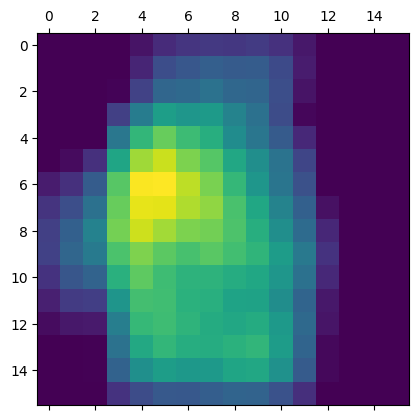

In [13]:
# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, base_layers, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

In [14]:

def save_and_display_gradcam(img_path, heatmap, alpha=0.4):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)
    
    superimposed_img.save('../results/figures/gradcam/gradcam_xception_{}.jpg'.format(phase))
    display(superimposed_img)
    

save_and_display_gradcam(img_path, heatmap)

/tmp/ipykernel_909287/77502472.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


NameError: name 'phase' is not defined

In [15]:
alpha = 0.2
for phase in os.listdir('../data/frames/train/'):
    #get 5 random files from the directory
    img_dir = '../data/frames/train/{}'.format(phase)
    img_list = os.listdir(img_dir)
    count = 0
    for i in range(25):
        img1 = img_list[np.random.randint(0, len(img_list))]

        img_path = os.path.join(img_dir, img1)
        img_array = preprocess_input(get_img_array(img_path, size=img_size))
        heatmap = make_gradcam_heatmap(img_array, base_layers, last_conv_layer_name)

        img = keras.preprocessing.image.load_img(img_path)
        img = keras.preprocessing.image.img_to_array(img)

        # Rescale heatmap to a range 0-255
        heatmap = np.uint8(255 * heatmap)

        # Use jet colormap to colorize heatmap
        jet = cm.get_cmap("jet")

        # Use RGB values of the colormap
        jet_colors = jet(np.arange(256))[:, :3]
        jet_heatmap = jet_colors[heatmap]

        # Create an image with RGB colorized heatmap
        jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
        jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
        jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

        # Superimpose the heatmap on original image
        superimposed_img = jet_heatmap * alpha + img
        superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)
        if not os.path.exists('../results/figures/gradcam/{}'.format(phase)):
            os.makedirs('../results/figures/gradcam/{}'.format(phase))
        superimposed_img.save('../results/figures/gradcam/{}/gradcam_xception_{}.jpg'.format(phase, count))
        count += 1

/tmp/ipykernel_909287/1686913888.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")
